In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from typing import Callable, Union, Literal, Optional
from pathlib import Path

import utils.pd as pd_utils
import utils.plt as plt_utils
import utils.sklrn as sklearn_utils
import utils.files as files_utils
from pandas.io.formats.style import Styler as pdStyler

import sklearn_pandas as skpd
from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder

from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import chi2, f_classif, SelectKBest

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
accuracy_score, recall_score, precision_score, f1_score, 
log_loss, confusion_matrix, auc, roc_auc_score, roc_curve,
RocCurveDisplay, ConfusionMatrixDisplay
)

import mlflow
import plotly
import shap

from joblib import Parallel, delayed

import optuna
import optuna.integration.xgboost as optuna_xgb
import optuna.integration.lightgbm as optuna_lgbm

from IPython.display import display

import os
from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/train_clean.csv')

In [3]:
pd_utils.display_dataframe(df)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Mortgage_Loan,Personal_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan,Payday_Loan,Auto_Loan,Not_Specified_Loan,Home_Equity_Loan,Student_Loan,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,24.785217,High_spent_Small_value_payments,321.851976,0,1,1,0,0,1,0,1,0,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,1,4.0,11.27,4.0,Good,809.98,31.944960,266.0,No,49.574949,24.785217,Low_spent_Large_value_payments,321.851976,0,1,1,0,0,1,0,1,0,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Good,809.98,28.609352,267.0,No,49.574949,24.785217,Low_spent_Medium_value_payments,321.851976,0,1,1,0,0,1,0,1,0,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,24.785217,Low_spent_Small_value_payments,321.851976,0,1,1,0,0,1,0,1,0,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,24.785217,High_spent_Medium_value_payments,321.851976,0,1,1,0,0,1,0,1,0,Good


In [4]:
data = df.drop(['ID', 'Customer_ID', 'Name', 'SSN'], axis=1)

In [5]:
X = data.drop(['Credit_Score'], axis=1)
y = data[['Credit_Score']]

In [6]:
oe = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])
oe.fit(y.values)
target = oe.transform(y.values)

In [7]:
numerical_cols = X.select_dtypes(include=np.number).columns.to_list()
categorical_cols = X.select_dtypes(exclude=np.number).columns.to_list()

In [8]:
def fs_report(features:pd.DataFrame, target:np.ndarray, test:Callable):
    fs_test = SelectKBest(score_func=test, k='all')
    index = None
    
    if test.__name__ == 'chi2':
        oe = OrdinalEncoder()
        features_encode = oe.fit_transform(features)
        index = features.columns.to_list()
        fs_test.fit(features_encode, target.ravel())
    elif test.__name__ == 'f_classif':  
        fs_test.fit(features, target.ravel())
        index = fs_test.feature_names_in_
    else:
        raise AttributeError('The type of test is not supported.')
        
    fs_df = (
        pd.DataFrame({
        'test_statistic': fs_test.scores_,
        'p_values': fs_test.pvalues_
        }, index=index)
            .sort_values('test_statistic', ascending=False)
    )

    return (
        fs_df.style
        .format('{:.2f}')
        .bar('test_statistic')
        .background_gradient(subset='test_statistic')
    )

In [9]:
anova_fs_report = fs_report(X[numerical_cols], target.ravel(), f_classif)
anova_fs_report

,test_statistic,p_values
Interest_Rate,15420.28,0.00
Num_Credit_Inquiries,11911.29,0.00
Delay_from_due_date,11450.77,0.00
Num_Credit_Card,9771.83,0.00
Num_Bank_Accounts,9280.40,0.00
Outstanding_Debt,9115.50,0.00
Credit_History_Age,8903.67,0.00
Num_of_Delayed_Payment,8833.23,0.00
Num_of_Loan,7440.63,0.00
Monthly_Balance,3901.64,0.00


In [10]:
chi2_fs_report = fs_report(X[categorical_cols], target.ravel(), chi2)
chi2_fs_report

,test_statistic,p_values
Payment_of_Min_Amount,9095.53,0.00
Credit_Mix,5845.83,0.00
Payment_Behaviour,1783.89,0.00
Occupation,26.93,0.00
Month,5.19,0.07


In [11]:
def visualize_fs_report(ax:plt.Axes, report:pdStyler):
    sns.barplot(data=report.data.reset_index(),
            x='index',
            y='test_statistic', 
            ax=ax)
    plt_utils.rotate_xticks_labels(ax, 90)
    plt_utils.turn_off_right_upper_spines(ax)
    ax.set_xlabel('')
    return ax

In [12]:
def visualize_feature_importance(num_features_report:pdStyler, cat_features_report:pdStyler):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    visualize_fs_report(axs[0], num_features_report)
    visualize_fs_report(axs[1], cat_features_report)
    axs[0].set_xlabel('Numerical Features')
    axs[0].set_ylabel('f-statistic')
    axs[1].set_xlabel('Categorical Features')
    axs[1].set_ylabel('chi2-statistic')
    return fig

In [13]:
# fig, ax = plt.subplots(figsize=(9, 6))
# visualize_fs_report(ax, anova_fs_report)
# plt.show()

In [14]:
# fig, ax = plt.subplots(figsize=(9, 6))
# visualize_fs_report(ax, chi2_fs_report)
# plt.show()

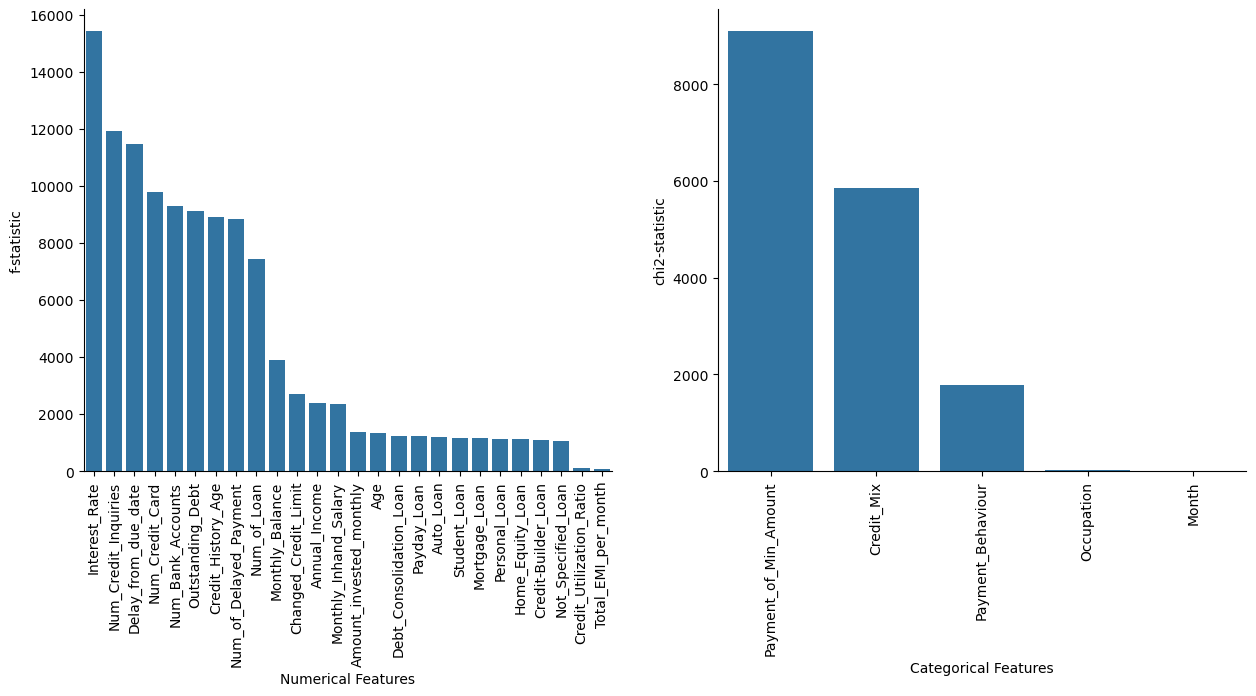

In [15]:
fig = visualize_feature_importance(anova_fs_report, chi2_fs_report)

In [16]:
cols_to_drop = ['Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Occupation', 'Month']

In [17]:
X_reduced = X.drop(cols_to_drop, axis=1)

In [18]:
X_reduced_num_cols = X_reduced.select_dtypes(include=np.number).columns.to_list()

In [19]:
X_reduced_cat_cols = X_reduced.select_dtypes(exclude=np.number).columns.to_list()

In [20]:
cols_to_onehot = ['Credit_Mix', 'Payment_of_Min_Amount']

pb_enc = OrdinalEncoder(categories= [
    ['Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments']
])

In [21]:
transformer1 = DataFrameMapper([
    *[( [col], OneHotEncoder(drop='first'), {'input_df':True} ) for col in cols_to_onehot],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols],
    (['Payment_Behaviour'], pb_enc, {'input_df':True})
], df_out=True)

transformer2 = DataFrameMapper([
    *[( [col], OneHotEncoder(drop='first'), {'input_df':True} ) for col in cols_to_onehot],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols],
    (['Payment_Behaviour'], [pb_enc, MinMaxScaler()], {'input_df':True})
], df_out=True, drop_cols=['Credit_Mix_Bad'])

transformer2_1 = DataFrameMapper([
    *[( [col], OneHotEncoder(drop='first'), {'input_df':True} ) for col in cols_to_onehot],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols],
    (['Payment_Behaviour'], [pb_enc, MinMaxScaler()], {'input_df':True})
], df_out=True, drop_cols=['Credit_Mix_Bad', 'Num_of_Loan', 'Monthly_Inhand_Salary'])

transformer2_2 = DataFrameMapper([
    *[( [col], OneHotEncoder(drop='first'), {'input_df':True} ) for col in cols_to_onehot],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols],
    (['Payment_Behaviour'], [pb_enc, MinMaxScaler()], {'input_df':True})
], df_out=True, drop_cols=['Credit_Mix_Bad', 'Num_of_Loan', 'Annual_Income'])

transformer3 = DataFrameMapper([
    *[( [col], TargetEncoder(), {'input_df':True} ) for col in X_reduced_cat_cols],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols]
], df_out=True)

transformer3_1 = DataFrameMapper([
    *[( [col], TargetEncoder(), {'input_df':True} ) for col in X_reduced_cat_cols],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols]
], df_out=True, drop_cols=['Num_of_Loan', 'Monthly_Inhand_Salary'])

transformer3_2 = DataFrameMapper([
    *[( [col], TargetEncoder(), {'input_df':True} ) for col in X_reduced_cat_cols],
    *[( [col], MinMaxScaler(), {'input_df':True} ) for col in X_reduced_num_cols]
], df_out=True, drop_cols=['Num_of_Loan', 'Annual_Income'])

In [22]:
def make_clf_pipeline(preprocessing_transformer:skpd.DataFrameMapper, model:sklearn_utils.ScikitModel, 
                      categorical:bool=False):
    smote_flavor = SMOTE() if not categorical else SMOTENC(categorical_features='auto')
    return Pipeline( 
        steps=[
            ('preprocessing', preprocessing_transformer),
            ('oversampling', smote_flavor),
            ('model', model)
        ])

In [23]:
def visualize_roc(y_test:np.ndarray, pred_proba:np.ndarray, labels:Optional[list]=None, figsize:tuple=(7,5)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    num_classes = pred_proba.shape[1]
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, pred_proba[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['orangered', 'deepskyblue', 'forestgreen']
    for i, color in zip(range(num_classes), colors):
        cls = labels[i] if labels else i
        ax.plot(fpr[i], tpr[i], color=color, lw=1.5,
                 label=f'ROC of class "{cls}" (AUC={roc_auc[i]:0.2f})')
        # ax.fill_between(fpr[i], tpr[i], color=color, alpha=.5)

    ax.plot([0, 1], [0, 1], color='dimgray', linestyle='--',lw=2.5)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate (fpr)')
    ax.set_ylabel('True Positive Rate (tpr)')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc="lower right")

    return ax

In [24]:
# def calculate_clf_metrics(model:sklearn_utils.ScikitModel, X_test:pd.DataFrame, y_test:np.ndarray):
#     pred = model.predict(X_test)
#     pred_proba = model.predict_proba(X_test)
#     Metrics = namedtuple('Metrics', ['accuracy', 'recall', 'precision', 'f1_score', 'logloss'])
#     return Metrics(
#         accuracy_score(y_test, pred),
#         recall_score(y_test, pred, average=None),
#         precision_score(y_test, pred, average=None),
#         f1_score(y_test, pred, average=None),
#         log_loss(y_test, pred_proba)
#     )

In [25]:
def calculate_clf_metrics_averaged(model:sklearn_utils.ScikitModel, X_test:pd.DataFrame, y_test:np.ndarray, 
                                   average:Literal['macro', 'micro']='macro'):
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    Metrics = namedtuple('Metrics', ['accuracy', 'recall', 'precision', 'f1_score', 'logloss', 'auc_roc'])
    return Metrics(
        accuracy_score(y_test, pred),
        recall_score(y_test, pred, average=average),
        precision_score(y_test, pred, average=average),
        f1_score(y_test, pred, average=average),
        log_loss(y_test, pred_proba),
        roc_auc_score(y_test, pred_proba, average=average, multi_class='ovr')
    )

In [26]:
def calculate_clf_metrics_averaged_cv(model:sklearn_utils.ScikitModel, X_train:pd.DataFrame, X_test:pd.DataFrame, 
                      y_train:np.ndarray, y_test:np.ndarray, cv:int, average:Literal['macro', 'micro']='macro'):
    X, y = pd.concat([X_train, X_test]), np.vstack((y_train, y_test))
    skf = StratifiedKFold(n_splits=cv)
    metrics_results = []
    for train_indecies, test_indecies in skf.split(X, y):
        X_train, X_test = X.iloc[train_indecies, :], X.iloc[test_indecies, :]
        y_train, y_test = y[train_indecies], y[test_indecies]
        model.fit(X_train, y_train)
        metrics = calculate_clf_metrics_averaged(model, X_test, y_test, average=average)
        metrics_results.append(metrics)

    metrics_avg = dict(pd.DataFrame([metrics_result._asdict() for metrics_result in metrics_results]).mean())

    return metrics_avg

In [27]:
def get_model_accuracy(model:sklearn_utils.ScikitModel, X_test:pd.DataFrame, y_test:np.ndarray):
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred)

In [28]:
def visualize_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray, labels:Optional[list]=None, figsize:tuple=(7,5)):
    cm = confusion_matrix(y_true, y_pred)
    labels = 'auto' if labels is None else labels
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data=cm, annot=True, xticklabels=labels, yticklabels=labels, 
                cbar=False, linecolor='dimgray', linewidths=.2, fmt='d', 
                cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.xaxis.set_label_position("top") 
    ax.set_ylabel('Actual labels')
    ax.yaxis.tick_right()
    
    return ax

In [29]:
def save_visualization(plt_obj:Union[plt.Axes, plt.Figure], fname:str, *args, **kwargs):
    if type(plt_obj) == 'matplotlib.figure.Figure':
        plt_obj.savefig(fname, *args, **kwargs)
    else:
        plt_obj.get_figure().savefig(fname, *args, **kwargs)

In [30]:
def get_data_context(df_name:str):
    df_first_char = df_name.split('_')[0]
    df_context = 'Training' if df_first_char == 'X' else 'Testing'
    return df_context

In [31]:
def run_experiment(experiment_name:str, X_train:pd.DataFrame, y_train:np.ndarray,
                   X_test:pd.DataFrame, y_test:np.ndarray, 
                   models:dict[str, sklearn_utils.ScikitModel], model_params:Optional[dict]=None,
                   artifacts_folder:Path=None, cv:Optional[int]=None, register_models:bool=False):

    if artifacts_folder is None:
        experiment_dirname = f'exp_{experiment_name}_artifacts'
        artifacts_folder = files_utils.create_dir(experiment_dirname, replace_existing=True)
    elif not Path.is_dir(artifacts_folder):
        raise OSError(f'Directory "{artifacts_folder}" doesn\'t exist, you may want to create it first.')

    
    mlflow_tracking_uri = os.getenv('MLFLOW_TRACKING_URI')
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    
    mlflow.set_experiment(experiment_name)

    progress_bar_models = tqdm(models.items())
    for model_name, model in progress_bar_models:
        progress_bar_models.set_description(f'Logging model [ {model_name} ]')
        
        with mlflow.start_run(run_name=f'{model_name}_run'):
            
            
            # Model fitting and calculating metrics
            if model_params is not None:
                # logging model params
                mlflow.log_params(model_params)
                params = {f'model__{k}':v for k, v in model_params.items()}
                model.set_params(**params).fit(X_train, y_train)
                metrics_dict = calculate_clf_metrics_averaged_cv(model, X_train, X_test, y_train, y_test, cv=cv) \
                                    if cv is not None \
                                else calculate_clf_metrics_averaged(model, X_test, y_test)._asdict()
            else:
                model.fit(X_train, y_train)
                metrics_dict = calculate_clf_metrics_averaged_cv(model, X_train, X_test, y_train, y_test, cv=cv) \
                                    if cv is not None \
                                else calculate_clf_metrics_averaged(model, X_test, y_test)._asdict()

                
            pred = model.predict(X_test)
            pred_probas = model.predict_proba(X_test)


            # logging the metrics
            for metric_name, metric_value in metrics_dict.items():
                mlflow.log_metric(metric_name, metric_value)
    
            # logging the model
            registered_model_name = model_name if register_models else None
            mlflow.sklearn.log_model(model, model_name, registered_model_name=registered_model_name)

            # logging metrics visualizations
            extension = 'png'
            
            plt.ioff()
            
            cm_filename = f'confusion_matrix_{model_name}'
            cm_path = artifacts_folder/f"{cm_filename}.{extension}"
            cm = visualize_confusion_matrix(y_test, pred, labels=['Poor', 'Standard', 'Good'])
            save_visualization(cm, cm_path)
            mlflow.log_artifact(cm_path, cm_filename)
            
            
            roc_auc_filename = f'roc_auc_{model_name}'
            roc_auc_path = artifacts_folder/f"{roc_auc_filename}.{extension}"
            roc_auc_display = visualize_roc(y_test, pred_probas, ['Poor', 'Standard', 'Good'])
            save_visualization(roc_auc_display, roc_auc_path)
            mlflow.log_artifact(roc_auc_path, roc_auc_filename)

In [32]:
rf_baseline_models = {
    'rf_baseline_trans1': make_clf_pipeline(transformer1, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans2': make_clf_pipeline(transformer2, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans2_1': make_clf_pipeline(transformer2_1, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans2_2': make_clf_pipeline(transformer2_2, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans3': make_clf_pipeline(transformer3, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans3_1': make_clf_pipeline(transformer3_1, RandomForestClassifier(n_jobs=-1)),
    'rf_baseline_trans3_2': make_clf_pipeline(transformer3_2, RandomForestClassifier(n_jobs=-1))
}

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=.1, random_state=123, stratify=target)

In [34]:
run_experiment("random_forest_baseline_variants", X_train, y_train, X_test, y_test, rf_baseline_models)

2024/01/16 00:51:53 INFO mlflow.tracking.fluent: Experiment with name 'random_forest_baseline_variants' does not exist. Creating a new experiment.


  0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
xgb_baseline_models = {
    'xgb_baseline_trans2_2': make_clf_pipeline(
        preprocessing_transformer=transformer2_2,
        model=XGBClassifier(tree_method='hist', n_jobs=-1)
    ),
    'xgb_baseline_trans3_2': make_clf_pipeline(
            preprocessing_transformer=transformer3_2,
            model=XGBClassifier(tree_method='hist', n_jobs=-1)
        )
}

In [36]:
run_experiment("xgboost_baseline_variants", X_train, y_train, X_test, y_test, xgb_baseline_models)

2024/01/16 01:03:21 INFO mlflow.tracking.fluent: Experiment with name 'xgboost_baseline_variants' does not exist. Creating a new experiment.


  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
lgbm_baseline_models = {
    'lgbm_baseline_trans2_2': make_clf_pipeline(
        preprocessing_transformer=transformer2_2,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1)
    ),
    'lgbm_baseline_trans3_2': make_clf_pipeline(
            preprocessing_transformer=transformer3_2,
            model=LGBMClassifier(objective='multiclass', n_jobs=-1)
        )
}

In [38]:
run_experiment("lgbm_baseline_variants", X_train, y_train, X_test, y_test, lgbm_baseline_models)

2024/01/16 01:03:56 INFO mlflow.tracking.fluent: Experiment with name 'lgbm_baseline_variants' does not exist. Creating a new experiment.


  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6330
[LightGBM] [Info] Number of data points in the train set: 143571, number of used features: 28
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6269
[LightGBM] [Info] Number of data points in the train set: 143571, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [39]:
loans_cols = [col for col in X_reduced.columns if ('Loan' in col) and (col != 'Num_of_Loan')]
loans_cols

['Mortgage_Loan',
 'Personal_Loan',
 'Credit-Builder_Loan',
 'Debt_Consolidation_Loan',
 'Payday_Loan',
 'Auto_Loan',
 'Not_Specified_Loan',
 'Home_Equity_Loan',
 'Student_Loan']

In [40]:
num_cols_without_loans = [col for col in X_reduced_num_cols if col not in loans_cols]

In [41]:
transformer4 = DataFrameMapper([
    (loans_cols, sklearn_utils.ReduceObjColsToOneCatCol(), {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True)

transformer4_1 = DataFrameMapper([
    (loans_cols, sklearn_utils.ReduceObjColsToOneCatCol(), {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True, drop_cols=['Num_of_Loan'])

transformer4_2 = DataFrameMapper([
    (loans_cols, sklearn_utils.ReduceObjColsToOneCatCol(), {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True, drop_cols=['Num_of_Loan', 'Annual_Income'])

transformer5 = DataFrameMapper([
    (loans_cols, [sklearn_utils.ReduceObjColsToOneCatCol(), TargetEncoder()], {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], TargetEncoder(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True)

transformer5_1 = DataFrameMapper([
    (loans_cols, [sklearn_utils.ReduceObjColsToOneCatCol(), TargetEncoder()], {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], TargetEncoder(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True, drop_cols=['Num_of_Loan'])

transformer5_2 = DataFrameMapper([
    (loans_cols, [sklearn_utils.ReduceObjColsToOneCatCol(), TargetEncoder()], {'alias':'Type_of_Loan', 'input_df':True}),
    *[([col], TargetEncoder(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in num_cols_without_loans]
], df_out=True, drop_cols=['Num_of_Loan', 'Annual_Income'])

transformer6 = DataFrameMapper([
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in X_reduced_num_cols]
], df_out=True)

transformer6_1 = DataFrameMapper([
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in X_reduced_num_cols]
], df_out=True, drop_cols=['Num_of_Loan'])

transformer6_2 = DataFrameMapper([
    *[([col], sklearn_utils.ConvertObjColsToCat(), {'input_df': True}) for col in X_reduced_cat_cols],
    *[([col], MinMaxScaler()) for col in X_reduced_num_cols]
], df_out=True, drop_cols=['Num_of_Loan', 'Annual_Income'])

In [42]:
xgb_baseline_models2 = {
    'xgb_baseline_trans4': make_clf_pipeline(
        preprocessing_transformer=transformer4,
        model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
        categorical=True
    ),
    'xgb_baseline_trans4_1': make_clf_pipeline(
        preprocessing_transformer=transformer4_1,
        model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
        categorical=True
    ),
    'xgb_baseline_trans4_2': make_clf_pipeline(
        preprocessing_transformer=transformer4_2,
        model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
        categorical=True
    ),
    'xgb_baseline_trans5': make_clf_pipeline(
            preprocessing_transformer=transformer5,
            model=XGBClassifier(tree_method='hist', n_jobs=-1)
        ),
    'xgb_baseline_trans5_1': make_clf_pipeline(
            preprocessing_transformer=transformer5_1,
            model=XGBClassifier(tree_method='hist', n_jobs=-1)
        ),
    'xgb_baseline_trans5_2': make_clf_pipeline(
            preprocessing_transformer=transformer5_2,
            model=XGBClassifier(tree_method='hist', n_jobs=-1)
        ),
    'xgb_baseline_trans6': make_clf_pipeline(
            preprocessing_transformer=transformer6,
            model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
            categorical=True
        ),
    'xgb_baseline_trans6_1': make_clf_pipeline(
            preprocessing_transformer=transformer6_1,
            model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
            categorical=True
        ),
    'xgb_baseline_trans6_2': make_clf_pipeline(
            preprocessing_transformer=transformer6_2,
            model=XGBClassifier(enable_categorical=True, tree_method='hist', n_jobs=-1),
            categorical=True
        ),
}

In [43]:
run_experiment("xgboost_baseline_variants_2", X_train, y_train, X_test, y_test, xgb_baseline_models2)

2024/01/16 01:04:31 INFO mlflow.tracking.fluent: Experiment with name 'xgboost_baseline_variants_2' does not exist. Creating a new experiment.


  0%|          | 0/9 [00:00<?, ?it/s]

In [44]:
lgbm_baseline_models2 = {
    'lgbm_baseline_trans4': make_clf_pipeline(
        preprocessing_transformer=transformer4,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    ),
    'lgbm_baseline_trans4_1': make_clf_pipeline(
        preprocessing_transformer=transformer4_1,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    ),
    'lgbm_baseline_trans4_2': make_clf_pipeline(
        preprocessing_transformer=transformer4_2,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    ),
    'lgbm_baseline_trans5': make_clf_pipeline(
        preprocessing_transformer=transformer5,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
    ),
    'lgbm_baseline_trans5_1': make_clf_pipeline(
        preprocessing_transformer=transformer5_1,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
    ),
    'lgbm_baseline_trans5_2': make_clf_pipeline(
        preprocessing_transformer=transformer5_2,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
    ),
    'lgbm_baseline_trans6': make_clf_pipeline(
        preprocessing_transformer=transformer6,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    ),
    'lgbm_baseline_trans6_1': make_clf_pipeline(
        preprocessing_transformer=transformer6_1,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    ),
    'lgbm_baseline_trans6_2': make_clf_pipeline(
        preprocessing_transformer=transformer6_2,
        model=LGBMClassifier(objective='multiclass', n_jobs=-1),
        categorical=True
    )
}

In [45]:
run_experiment("lgbm_baseline_variants_2", X_train, y_train, X_test, y_test, lgbm_baseline_models2)

2024/01/16 01:20:20 INFO mlflow.tracking.fluent: Experiment with name 'lgbm_baseline_variants_2' does not exist. Creating a new experiment.


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7316
[LightGBM] [Info] Number of data points in the train set: 143571, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 

In [46]:
class Objective_rf_trans2_2():
    def __init__(self, X, y, cv=5):
        self.X, self.y = X, y
        self.cv = cv

    def __call__(self, trial:optuna.Trial):
        X, y = self.X, self.y
        
        params = {
            "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=500),
            "min_samples_split": trial.suggest_int(name="min_samples_split", low=3, high=10),
            "max_features": trial.suggest_categorical(name="max_features", choices=['sqrt', 'log2', None]) ,
            "max_depth": trial.suggest_int(name="max_depth", low=10, high=110, step=10),
            "min_samples_leaf": trial.suggest_int(name="min_samples_leaf", low=1, high=5, step=1)         
        }

        model = make_clf_pipeline(transformer2_2, 
                              RandomForestClassifier(random_state=123, bootstrap=True, **params))
        
        cv = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=1234)
        accuracy = cross_val_score(model, X, y, cv=cv,  n_jobs=-1).mean()
    
        return accuracy

In [47]:
# optuna.delete_study(study_name="rf_trans2_2", storage='sqlite:///optuna.db')

In [48]:
objective_rf_trans2_2 = Objective_rf_trans2_2(X_reduced, target, cv=10)

In [52]:
rf_study = optuna.create_study(direction="maximize", study_name="rf_trans2_2", 
                               storage='sqlite:///optuna.db', load_if_exists=True)
rf_study.optimize(objective_rf_trans2_2, n_trials=15, n_jobs=-1)

[I 2024-01-16 04:10:52,323] Using an existing study with name 'rf_trans2_2' instead of creating a new one.
[I 2024-01-16 04:37:02,036] Trial 9 finished with value: 0.80901 and parameters: {'n_estimators': 147, 'min_samples_split': 9, 'max_features': None, 'max_depth': 80, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8222900000000001.
[I 2024-01-16 05:03:16,616] Trial 5 finished with value: 0.8177299999999998 and parameters: {'n_estimators': 178, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 90, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8222900000000001.
[I 2024-01-16 05:24:19,516] Trial 7 finished with value: 0.81007 and parameters: {'n_estimators': 257, 'min_samples_split': 10, 'max_features': None, 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8222900000000001.
[I 2024-01-16 05:34:50,994] Trial 8 finished with value: 0.8197300000000001 and parameters: {'n_estimators': 331, 'min_samples_split': 9, 'max_features': 'sqrt', 'm

In [53]:
def visualize_hyper_params_importance(study: optuna.study.Study):
    param_importance_plot = optuna.visualization.plot_param_importances(study)
    param_importance_plot.show()

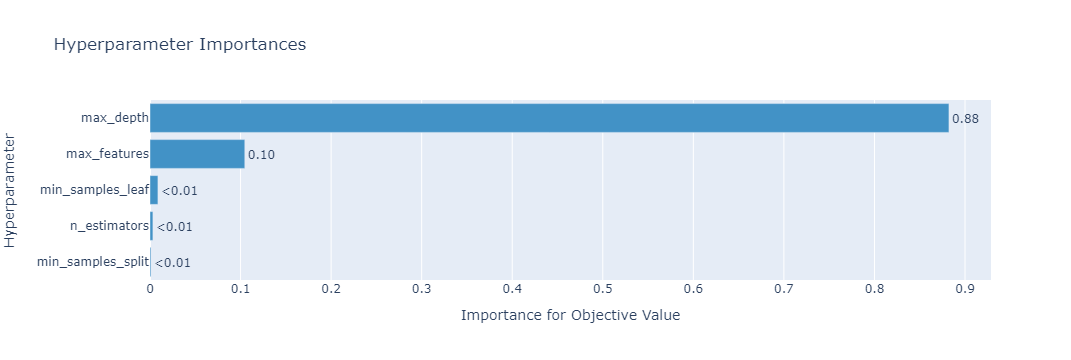

In [54]:
visualize_hyper_params_importance(rf_study)

In [55]:
run_experiment("fine_tunned_models", 
               X_train, y_train, X_test, y_test, 
               models={'rf_best': rf_baseline_models['rf_baseline_trans2_2']},
               model_params=rf_study.best_params,
               cv=10, register_models=True
              )

2024/01/16 07:59:44 INFO mlflow.tracking.fluent: Experiment with name 'fine_tunned_models' does not exist. Creating a new experiment.


  0%|          | 0/1 [00:00<?, ?it/s]

Successfully registered model 'rf_best'.
2024/01/16 08:12:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: rf_best, version 1
Created version '1' of model 'rf_best'.


In [56]:
class Objective_xgb_trans5_2():
    def __init__(self, X, y, cv=5):
        self.X, self.y = X, y
        self.cv = cv

    def __call__(self, trial:optuna.Trial):
        X, y = self.X, self.y
        
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
            'eval_metric': 'mlogloss',
        }


        model = make_clf_pipeline(transformer5_2, XGBClassifier(**params))
        
        cv = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=1234)
        accuracy = cross_val_score(model, X, y, cv=cv,  n_jobs=-1).mean()
    
        return accuracy

In [57]:
objective_xgb_trans5_2 = Objective_xgb_trans5_2(X_reduced, target, cv=10)

In [58]:
# optuna.delete_study(study_name="xgb_trans5_2", storage='sqlite:///optuna.db')

In [59]:
xgb_study = optuna.create_study(direction="maximize", study_name="xgb_trans5_2", 
                                storage='sqlite:///optuna.db', load_if_exists=True)
xgb_study.optimize(objective_xgb_trans5_2, n_trials=15, n_jobs=-1)

[I 2024-01-16 08:12:34,470] A new study created in RDB with name: xgb_trans5_2
[I 2024-01-16 08:18:29,281] Trial 1 finished with value: 0.80419 and parameters: {'max_depth': 7, 'learning_rate': 0.9479665470559651, 'n_estimators': 408, 'min_child_weight': 9, 'gamma': 0.7344570550599854, 'subsample': 0.6270761127703843, 'colsample_bytree': 0.1983157154218156, 'reg_alpha': 0.3313659238246194, 'reg_lambda': 0.20824277539263275}. Best is trial 1 with value: 0.80419.
[I 2024-01-16 08:18:44,033] Trial 5 finished with value: 0.7277899999999999 and parameters: {'max_depth': 2, 'learning_rate': 0.29057553119058893, 'n_estimators': 210, 'min_child_weight': 9, 'gamma': 0.7116981976074238, 'subsample': 0.9785531913418152, 'colsample_bytree': 0.15489252229952646, 'reg_alpha': 0.8994712744967637, 'reg_lambda': 0.5153029935141368}. Best is trial 1 with value: 0.80419.
[I 2024-01-16 08:22:17,797] Trial 0 finished with value: 0.70955 and parameters: {'max_depth': 6, 'learning_rate': 0.5222154923385701, 

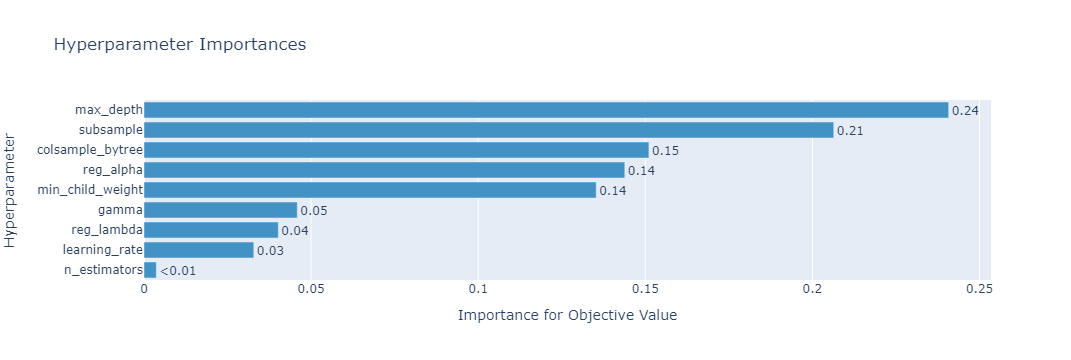

In [60]:
visualize_hyper_params_importance(xgb_study)

In [61]:
run_experiment("fine_tunned_models", 
               X_train, y_train, X_test, y_test, 
               models={'xgb_best': xgb_baseline_models2['xgb_baseline_trans5_2']},
               model_params=xgb_study.best_params,
               cv=10, register_models=True
              )

  0%|          | 0/1 [00:00<?, ?it/s]

Successfully registered model 'xgb_best'.
2024/01/16 09:22:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_best, version 1
Created version '1' of model 'xgb_best'.


In [62]:
class Objective_lgbm_trans4_2():
    def __init__(self, X, y, cv=5):
        self.X, self.y = X, y
        self.cv = cv

    def __call__(self, trial:optuna.Trial):
        X, y = self.X, self.y
        
        params = {
            "objective": "multiclass",
            "metric": "softmax",
            "boosting_type": "dart",
            "num_class": 3,
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }


        model = make_clf_pipeline(transformer4_2, LGBMClassifier(**params), categorical=True)
        
        cv = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=1234)
        accuracy = cross_val_score(model, X, y, cv=cv,  n_jobs=-1).mean()
    
        return accuracy

In [63]:
objective_lgbm_trans4_2 = Objective_lgbm_trans4_2(X_reduced, target, cv=10)

In [64]:
# optuna.delete_study(study_name="lgbm_trans4_2", storage='sqlite:///optuna.db')

In [65]:
lgbm_study = optuna.create_study(direction="maximize", study_name="lgbm_trans4_2", 
                                 storage='sqlite:///optuna.db', load_if_exists=True)
lgbm_study.optimize(objective_lgbm_trans4_2, n_trials=15, n_jobs=-1)

[I 2024-01-16 09:22:12,822] A new study created in RDB with name: lgbm_trans4_2
[W 2024-01-16 09:53:14,925] Trial 6 failed with parameters: {'learning_rate': 0.007064295360405646, 'lambda_l2': 0.22273718683977006, 'num_leaves': 95, 'feature_fraction': 0.935582620240267, 'bagging_fraction': 0.9195413679876278, 'bagging_freq': 6, 'min_child_samples': 12} because of the following error: The value nan is not acceptable.
[W 2024-01-16 09:53:15,048] Trial 6 failed with value nan.
[W 2024-01-16 10:22:49,697] Trial 5 failed with parameters: {'learning_rate': 0.0037016021191141825, 'lambda_l2': 5.032981126523677e-05, 'num_leaves': 255, 'feature_fraction': 0.5132862129037397, 'bagging_fraction': 0.7417495463192769, 'bagging_freq': 4, 'min_child_samples': 86} because of the following error: The value nan is not acceptable.
[W 2024-01-16 10:22:49,828] Trial 5 failed with value nan.
[I 2024-01-16 10:42:15,249] Trial 2 finished with value: 0.7131799999999999 and parameters: {'learning_rate': 0.00732

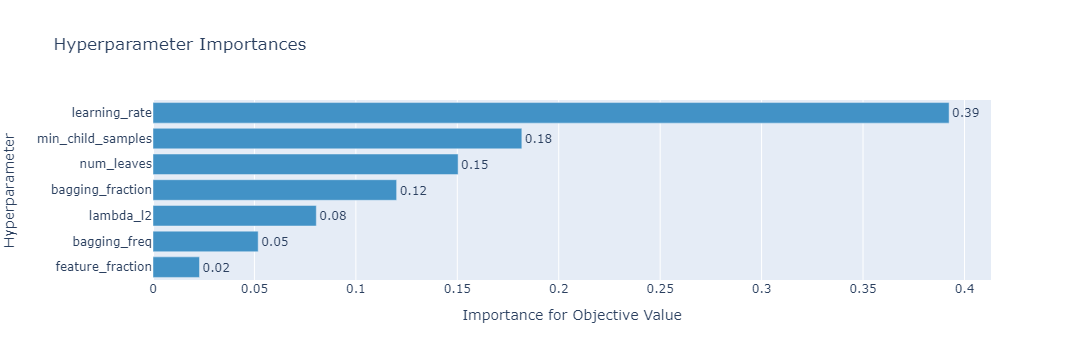

In [66]:
visualize_hyper_params_importance(lgbm_study)

In [67]:
run_experiment("fine_tunned_models", 
               X_train, y_train, X_test, y_test, 
               models={'lgbm_best': lgbm_baseline_models2['lgbm_baseline_trans4_2']},
               model_params=lgbm_study.best_params,
               cv=10, register_models=True
              )

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9807385309765674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9807385309765674
[LightGBM] [Warning] lambda_l2 is set=0.7449847005851707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7449847005851707
[LightGBM] [Warning] bagging_fraction is set=0.7258619532752049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7258619532752049
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9807385309765674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9807385309765674
[LightGBM] [Warning] lambda_l2 is set=0.7449847005851707, reg_lambda=0.0

Successfully registered model 'lgbm_best'.
2024/01/16 14:28:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm_best, version 1
Created version '1' of model 'lgbm_best'.


In [68]:
champ_pipeline = rf_baseline_models['rf_baseline_trans2_2']

In [69]:
preprocessor = champ_pipeline[0]

In [70]:
rf_best_model = champ_pipeline[-1].set_params(**rf_study.best_params)

In [72]:
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.fit_transform(X_test, y_test)

In [73]:
explainer = shap.KernelExplainer(rf_best_model.predict, shap.sample(X_train_transformed, 100))

In [74]:
shap_values = explainer.shap_values(shap.sample(X_test_transformed, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

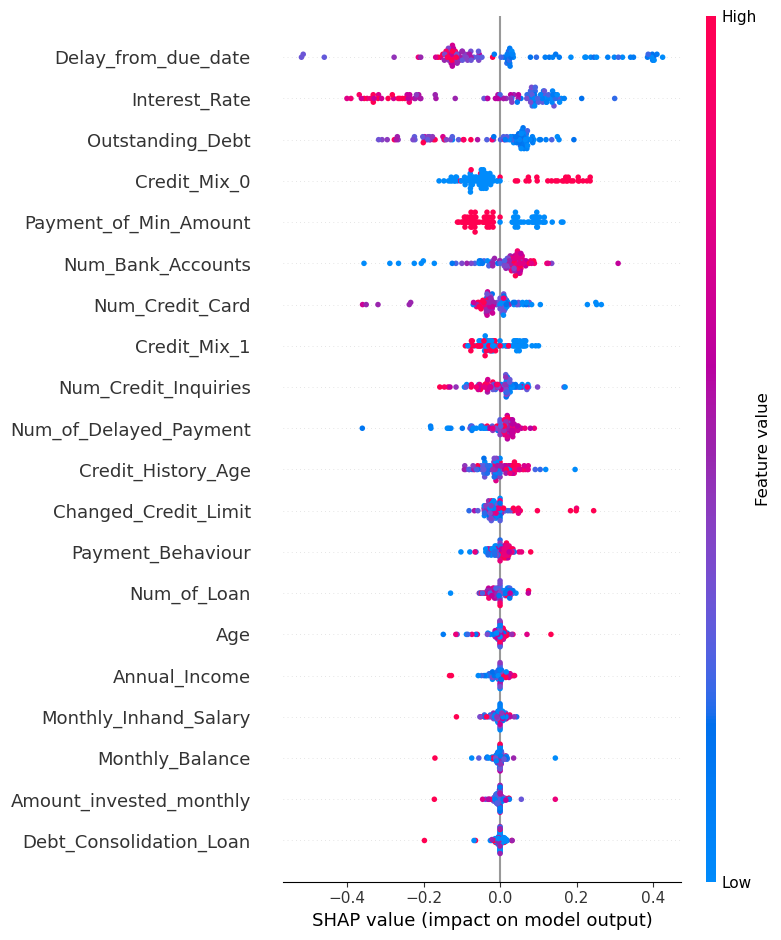

In [98]:
shap.summary_plot(shap_values, shap.sample(X_test_transformed, 100))
plt.show()